# Spooky author identification



##### End to end deep learning with LSTM approach: no feature engineering ,just lots of data and lots of hidden layers.

Additional to original Kaggle dataset, i also use external data i've compiled in another of my AI projects(a generative model that learns to generate new text combining lovecraft and Poe styles):
https://github.com/llealgt/edgar_philip_love_poe

In [1]:
import numpy as np
import tensorflow as tf
import csv
from sklearn import preprocessing
from string import punctuation
from sklearn import metrics
import matplotlib.pyplot as plt
import random

In [2]:
reviews = []
labels = []
test = []
test_ids = []
external_authors = []
external_lines = []
with open('./text.csv', 'r',encoding="latin-1") as f:
    text_reader = csv.reader(f,delimiter=",")
    next(text_reader)
    for row in text_reader:
        reviews.append(row[0])
with open('./author.csv', 'r') as labels_csv:
    author_reader = csv.reader(labels_csv,delimiter =",")
    next(author_reader) #ignore header
    for row in author_reader:
        labels.append(row[0])
with open("./test.csv",'r') as test_csv:
    text_reader = csv.reader(test_csv, delimiter= ",")
    next(text_reader) #ignore header
    
    for row in text_reader:
        test_ids.append(row[0])
        test.append(row[1])
        
with open("./newData.csv",'r') as external_data:
    text_reader = csv.reader(external_data,delimiter=",")
    
    for row in text_reader:
        line = row[1].strip()
        
        if len(line.split() )> 5: #if the line has at least 5 words, keep it
            external_authors.append(row[0].strip())
            external_lines.append(line)

In [3]:
len(reviews)

19579

In [4]:
len(test)

8392

In [5]:
len(external_authors)

54058

In [6]:
reviews[:20]

['This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.',
 'It never once occurred to me that the fumbling might be a mere mistake.',
 'In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.',
 'How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath, speckled by happy cottages and wealthier towns, all looked as in former years, heart cheering and fair.',
 'Finding nothing else, not even gold, the Superintendent abandoned his attempts; but a perplexed look occasionally steals over his countenance as he sits thinking at his desk.',
 'A youth passed in solitude, my best years spent under your gentle and feminine fosterage, h

In [7]:
labels[:20]

['EAP',
 'HPL',
 'EAP',
 'MWS',
 'HPL',
 'MWS',
 'EAP',
 'EAP',
 'EAP',
 'MWS',
 'MWS',
 'EAP',
 'HPL',
 'HPL',
 'EAP',
 'MWS',
 'EAP',
 'MWS',
 'EAP',
 'HPL']

In [8]:
test[:20]

['Still, as I urged our leaving Ireland with such inquietude and impatience, my father thought it best to yield.',
 'If a fire wanted fanning, it could readily be fanned with a newspaper, and as the government grew weaker, I have no doubt that leather and iron acquired durability in proportion, for, in a very short time, there was not a pair of bellows in all Rotterdam that ever stood in need of a stitch or required the assistance of a hammer.',
 'And when they had broken down the frail door they found only this: two cleanly picked human skeletons on the earthen floor, and a number of singular beetles crawling in the shadowy corners.',
 'While I was thinking how I should possibly manage without them, one actually tumbled out of my head, and, rolling down the steep side of the steeple, lodged in the rain gutter which ran along the eaves of the main building.',
 'I am not sure to what limit his knowledge may extend.',
 '"The thick and peculiar mist, or smoke, which distinguishes the Indi

In [9]:
external_lines[:20]

['AT THE MOUNTAINS OF MADNESS  I.  I am forced into speech because men of science have refused to follow my advice without knowing why.',
 'It is altogether against my will that I tell my reasons for opposing this contemplated invasion of the antarctic—with its vast fossil-hunt and its wholesale boring and melting of the ancient ice-cap—and I am the more reluctant because my warning may be in vain.',
 'Doubt of the real facts, as I must reveal them, is inevitable; yet if I suppressed what will seem extravagant and incredible there would be nothing left.',
 'The hitherto withheld photographs, both ordinary and aërial, will count in my favour; for they are damnably vivid and graphic.',
 'Still, they will be doubted because of the great lengths to which clever fakery can be carried.',
 'The ink drawings, of course, will be jeered at as obvious impostures; notwithstanding a strangeness of technique which art experts ought to remark and puzzle over.',
 'In the end I must rely on the judgmen

## Data preprocessing

The first step when building a neural network model is getting your data into the proper form to feed into the network. Since we're using embedding layers, we'll need to encode each word with an integer. We'll also want to clean it up a bit.

You can see an example of the reviews data above. We'll want to get rid of those periods. Also, you might notice that the reviews are delimited with newlines `\n`. To deal with those, I'm going to split the text into each review using `\n` as the delimiter. Then I can combined all the reviews back together into one big string.

First, let's remove all punctuation. Then get all the text without the newlines and split it into individual words.

In [10]:
from string import punctuation
#all_text = ' '.join([c for c in reviews + test if c not in punctuation])
all_text = ' '.join([c for c in reviews + test +external_lines])

words = all_text.split()

In [11]:
all_text[:305]

'This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall. It never once occurred to me that the fumbling might be a mere mistake. I'

In [12]:
words[:100]

['This',
 'process,',
 'however,',
 'afforded',
 'me',
 'no',
 'means',
 'of',
 'ascertaining',
 'the',
 'dimensions',
 'of',
 'my',
 'dungeon;',
 'as',
 'I',
 'might',
 'make',
 'its',
 'circuit,',
 'and',
 'return',
 'to',
 'the',
 'point',
 'whence',
 'I',
 'set',
 'out,',
 'without',
 'being',
 'aware',
 'of',
 'the',
 'fact;',
 'so',
 'perfectly',
 'uniform',
 'seemed',
 'the',
 'wall.',
 'It',
 'never',
 'once',
 'occurred',
 'to',
 'me',
 'that',
 'the',
 'fumbling',
 'might',
 'be',
 'a',
 'mere',
 'mistake.',
 'In',
 'his',
 'left',
 'hand',
 'was',
 'a',
 'gold',
 'snuff',
 'box,',
 'from',
 'which,',
 'as',
 'he',
 'capered',
 'down',
 'the',
 'hill,',
 'cutting',
 'all',
 'manner',
 'of',
 'fantastic',
 'steps,',
 'he',
 'took',
 'snuff',
 'incessantly',
 'with',
 'an',
 'air',
 'of',
 'the',
 'greatest',
 'possible',
 'self',
 'satisfaction.',
 'How',
 'lovely',
 'is',
 'spring',
 'As',
 'we',
 'looked',
 'from',
 'Windsor']

### Encoding the words

The embedding lookup requires that we pass in integers to our network. The easiest way to do this is to create dictionaries that map the words in the vocabulary to integers. Then we can convert each of our reviews into integers so they can be passed into the network.

> **Exercise:** Now you're going to encode the words with integers. Build a dictionary that maps words to integers. Later we're going to pad our input vectors with zeros, so make sure the integers **start at 1, not 0**.
> Also, convert the reviews to integers and store the reviews in a new list called `reviews_ints`. 

In [13]:
reviews[2]

'In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.'

In [14]:
# Create your dictionary that maps vocab words to integers here
vocab_to_int = {word:index for index,word in enumerate(set(words),1)}
vocab_to_int["<PAD>"] = 0

# Convert the reviews to integers, same shape as reviews list, but with integers
reviews_ints = []
for review in reviews:
    reviews_ints.append([vocab_to_int[word] for word in review.split()])
    
test_ints = []
for test_line in test:
    test_ints.append([vocab_to_int[word] for word in test_line.split()])
    
external_ints = []

for external_line in external_lines:
    external_ints.append([vocab_to_int[word] for word in external_line.split()])

In [15]:
len(vocab_to_int)

100754

In [16]:
reviews_ints[1]

[42178,
 38138,
 70482,
 92423,
 7083,
 87546,
 52942,
 46556,
 81495,
 26446,
 70834,
 16563,
 16664,
 21379]

In [17]:
test_ints[1]

[33975,
 16563,
 67031,
 73900,
 84344,
 18984,
 81512,
 4988,
 70834,
 69616,
 12455,
 16563,
 95313,
 26978,
 84291,
 46556,
 31374,
 97441,
 84733,
 21816,
 4348,
 64366,
 28775,
 52942,
 4495,
 26978,
 81392,
 36852,
 74649,
 83252,
 57096,
 75740,
 83252,
 16563,
 72058,
 32456,
 94033,
 85939,
 49760,
 34307,
 16563,
 8078,
 29013,
 63101,
 83252,
 39220,
 26460,
 52942,
 46094,
 97702,
 83252,
 76962,
 29013,
 16563,
 44714,
 62244,
 47895,
 46556,
 18945,
 29013,
 16563,
 47841]

### Encoding the labels

Our labels are "positive" or "negative". To use these labels in our network, we need to convert them to 0 and 1.

> **Exercise:** Convert labels from `positive` and `negative` to 1 and 0, respectively.

In [18]:
labels_to_int = {}
int_to_labels = {}
unique_labels = list(set(labels))
for i,label in enumerate(unique_labels):
    labels_to_int[label] = i
    int_to_labels[i] = label
    
int_labels = []

for label in labels:
    int_labels.append(labels_to_int[label])
    
int_external_labels = []

for label in external_authors:
    int_external_labels.append(labels_to_int[label])
    
print(labels_to_int)
print(int_to_labels)
print(int_labels[:10])

{'EAP': 0, 'HPL': 1, 'MWS': 2}
{0: 'EAP', 1: 'HPL', 2: 'MWS'}
[0, 1, 0, 2, 1, 2, 0, 0, 0, 2]


In [19]:
encoder = preprocessing.LabelBinarizer()
encoder.fit(list(set(int_labels)))
one_hot_labels = encoder.transform(int_labels)
                                   
one_hot_labels

one_hot_external_labels = encoder.transform(int_external_labels)

one_hot_external_labels

array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       ..., 
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

In [20]:
from collections import Counter
review_lens = Counter([len(x) for x in reviews_ints])
print("Zero-length reviews: {}".format(review_lens[0]))
print("Maximum review length: {}".format(max(review_lens)))
print("Minimum length: {}".format(min(review_lens)))
print("Average length: {}".format(sum(review_lens)/len(review_lens)))

Zero-length reviews: 0
Maximum review length: 861
Minimum length: 2
Average length: 92.09655172413792


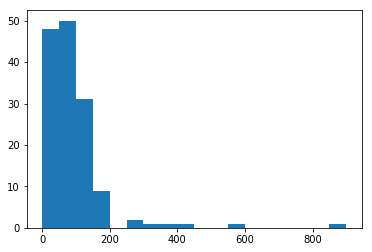

In [21]:
%matplotlib inline
text_lens_list = list(review_lens)
p,h,s = plt.hist(text_lens_list,bins = [0,50,100,150,200,250,300,350,400,450,500,550,600,650,700,750,800,850,900])

In [22]:
for  i in range(len(p)):
    print(p[i]/len(text_lens_list)  ,"% is between ",h[i]," and ",h[i+1])

0.331034482759 % is between  0  and  50
0.344827586207 % is between  50  and  100
0.213793103448 % is between  100  and  150
0.0620689655172 % is between  150  and  200
0.0 % is between  200  and  250
0.0137931034483 % is between  250  and  300
0.00689655172414 % is between  300  and  350
0.00689655172414 % is between  350  and  400
0.00689655172414 % is between  400  and  450
0.0 % is between  450  and  500
0.0 % is between  500  and  550
0.00689655172414 % is between  550  and  600
0.0 % is between  600  and  650
0.0 % is between  650  and  700
0.0 % is between  700  and  750
0.0 % is between  750  and  800
0.0 % is between  800  and  850
0.00689655172414 % is between  850  and  900


aproximatly 67% of text lengths is between 0 and 100 , and 88% between 0 and 150, we can use 100 or 150 for seq lenght

In [23]:
test_lens = Counter([len(x) for x in test_ints])
print("Zero-length reviews: {}".format(test_lens[0]))
print("Maximum review length: {}".format(max(test_lens)))
print("Minimum length: {}".format(min(test_lens)))
print("Average length: {}".format(sum(test_lens)/len(test_lens)))

Zero-length reviews: 0
Maximum review length: 818
Minimum length: 3
Average length: 77.57377049180327


The maximum review length is way too many steps for our RNN. Let's truncate to 100 steps. For reviews shorter than 100, we'll pad with 0s. For reviews longer than 100, we can truncate them to the first 200 characters.

Now, create an array `features` that contains the data we'll pass to the network. The data should come from text ints, since we want to feed integers to the network. Each row should be 100 elements long. For lubes shorter than 200 words, left pad with 0s. 


In [24]:
seq_len = 100
features = []

for review in reviews_ints:
    review_size = len(review)
    if review_size < seq_len:
        padded_review = [0] * seq_len
        padded_review[seq_len-len(review):seq_len] = review
    elif review_size > seq_len:
        padded_review = review[:seq_len]
    
    features.append(padded_review)
features  = np.array(features)

In [25]:
features[:10,:100]

array([[     0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,  56771,  34050,  25793,  48113,  87546,
         64366,  67442,  29013,   5930,  46556,  18891,  29013,   1863,
         43525,  84291,  21816,  26446,  42186,  74870,  91559,  26978,
         72741,   7083,  46556,  10099,   2212,  21816,  24074,  20513,
          9862,   4825,  72456,  29013,  46556,  24614,  45941,    590,
          3882,  15097,  46556,  25645],
       [     0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,

In [26]:
test_features = []

for test_line in test_ints:
    line_size = len(test_line)
    if line_size < seq_len:
        padded_line = [0] * seq_len
        padded_line[seq_len-len(test_line):seq_len] = test_line
    elif line_size > seq_len:
        padded_line = test_line[:seq_len]
        
    test_features.append(padded_line)

test_features = np.array(test_features)

In [27]:
test_features.shape

(8392, 100)

In [28]:
test_features[:10,:100]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
        53178, 84291, 21816, 20391, 94015, 88209, 96930, 12455, 53351,
        86086, 26978, 86196,  1863,  3753, 38346, 18984, 62243,  7083,
        66281],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     

In [29]:
external_features = []

for external_line in external_ints:
    line_size = len(external_line)
    if line_size < seq_len:
        padded_line = [0] * seq_len
        padded_line[seq_len-len(external_line):seq_len] = external_line
    elif line_size > seq_len:
        padded_line = external_line[:seq_len]
        
    external_features.append(padded_line)

external_features = np.array(external_features)

## Training, Validation, Test



With our data in nice shape, we'll split it into training, validation, and test sets.

In [30]:
split_frac = 0.80

split_index  = int(len(features)*split_frac)

train_x, val_x = features[:split_index],features[split_index:]
train_y, val_y = one_hot_labels[:split_index],one_hot_labels[split_index:]

split_index = int(len(val_x)/2)

val_x, test_x = val_x[:split_index],val_x[split_index:]
val_y, test_y = val_y[:split_index],val_y[split_index:]

# add external data to traininig set
train_x = np.append(train_x, external_features,axis = 0)
train_y = np.append(train_y, one_hot_external_labels,axis= 0)
random_indexes = np.random.permutation(train_x.shape[0])

train_x = train_x[random_indexes]
train_y = train_y[random_indexes]

print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), train_y.shape, 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))


			Feature Shapes:
Train set: 		(69721, 100) (69721, 3) 
Validation set: 	(1958, 100) 
Test set: 		(1958, 100)


## Build the graph

Here, we'll build the graph. First up, defining the hyperparameters.

* `lstm_size`: Number of units in the hidden layers in the LSTM cells. Usually larger is better performance wise. Common values are 128, 256, 512, etc.
* `lstm_layers`: Number of LSTM layers in the network. I'd start with 1, then add more if I'm underfitting.
* `batch_size`: The number of reviews to feed the network in one training pass. Typically this should be set as high as you can go without running out of memory.
* `learning_rate`: Learning rate

In [31]:
lstm_size = 256
fully_connected_size = 15
lstm_layers = 1
fully_connected_layers = 2
batch_size = 512
learning_rate = 0.005
dropout_lstm = 0.9
dropout_fully_connected = 0.9
display_every_iterations = 20 

In [32]:
def get_configuration_string(lstm_layers,lstm_size,fully_connected_layers,fully_connected_size,batch_size,learning_rate,lstm_dropout,fully_connected_dropout):
    configuration_string = "lstm_layers={}&lstm_size={}&fully_connected_layers={}&\
fully_connected_size={}&batch_size={}&learning_rate={}&lstm_dropout={}&fully_connected_dropout={}" \
    .format(lstm_layers,lstm_size,fully_connected_layers,fully_connected_size,batch_size,learning_rate,lstm_dropout,fully_connected_dropout)
    
    return configuration_string
    
get_configuration_string(lstm_layers,lstm_size,fully_connected_layers,fully_connected_size,batch_size,learning_rate,dropout_lstm,dropout_fully_connected)

'lstm_layers=1&lstm_size=256&fully_connected_layers=2&fully_connected_size=15&batch_size=512&learning_rate=0.005&lstm_dropout=0.9&fully_connected_dropout=0.9'

For the network itself, we'll be passing in our 100 element long review vectors. Each batch will be `batch_size` vectors. We'll also be using dropout on the LSTM layer, so we'll make a placeholder for the keep probability.

In [33]:
n_words = len(vocab_to_int)

# Create the graph object
graph = tf.Graph()
# Add nodes to the graph
with graph.as_default():
    inputs_ = tf.placeholder(tf.int32,shape=[batch_size,None],name="inputs")
    labels_ = tf.placeholder(tf.int32,shape=[batch_size,len(unique_labels)],name = "labels")
    keep_prob = tf.placeholder(tf.float32,name ="keep_prob")
    fully_connected_keep_prob = tf.placeholder(tf.float32,name = "fc_keep_prob")
    learning_rate_ = tf.placeholder(tf.float32,name = "learning_rate") 

### Embedding

Now we'll add an embedding layer. We need to do this because there are many words in our vocabulary. It is massively inefficient to one-hot encode our classes here. Instead of one-hot encoding, we can have an embedding layer and use that layer as a lookup table. You could train an embedding layer using word2vec, then load it here. But, it's fine to just make a new layer and let the network learn the weights.

 Create the embedding lookup matrix as a `tf.Variable`. Use that embedding matrix to get the embedded vectors to pass to the LSTM cell with [`tf.nn.embedding_lookup`](https://www.tensorflow.org/api_docs/python/tf/nn/embedding_lookup). This function takes the embedding matrix and an input tensor, such as the review vectors. Then, it'll return another tensor with the embedded vectors. So, if the embedding layer has 200 units, the function will return a tensor with size [batch_size, 200].



In [34]:
# Size of the embedding vectors (number of units in the embedding layer)
embed_size = 300 

with graph.as_default():
    embedding = tf.Variable(tf.random_uniform((n_words,embed_size),-0.5,0.5))
    embed = tf.nn.embedding_lookup(embedding,inputs_)

### LSTM cell

<img src="assets/network_diagram.png" width=400px>

Next, we'll create our LSTM cells to use in the recurrent network ([TensorFlow documentation](https://www.tensorflow.org/api_docs/python/tf/contrib/rnn)). Here we are just defining what the cells look like. This isn't actually building the graph, just defining the type of cells we want in our graph.

To create a basic LSTM cell for the graph, you'll want to use `tf.contrib.rnn.BasicLSTMCell`. Looking at the function documentation:

```
tf.contrib.rnn.BasicLSTMCell(num_units, forget_bias=1.0, input_size=None, state_is_tuple=True, activation=<function tanh at 0x109f1ef28>)
```

you can see it takes a parameter called `num_units`, the number of units in the cell, called `lstm_size` in this code. So then, you can write something like 

```
lstm = tf.contrib.rnn.BasicLSTMCell(num_units)
```

to create an LSTM cell with `num_units`. Next, you can add dropout to the cell with `tf.contrib.rnn.DropoutWrapper`. This just wraps the cell in another cell, but with dropout added to the inputs and/or outputs. It's a really convenient way to make your network better with almost no effort! So you'd do something like

```
drop = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)
```

Most of the time, your network will have better performance with more layers. That's sort of the magic of deep learning, adding more layers allows the network to learn really complex relationships. Again, there is a simple way to create multiple layers of LSTM cells with `tf.contrib.rnn.MultiRNNCell`:

```
cell = tf.contrib.rnn.MultiRNNCell([drop] * lstm_layers)
```

Here, `[drop] * lstm_layers` creates a list of cells (`drop`) that is `lstm_layers` long. The `MultiRNNCell` wrapper builds this into multiple layers of RNN cells, one for each cell in the list.

So the final cell you're using in the network is actually multiple (or just one) LSTM cells with dropout. But it all works the same from an achitectural viewpoint, just a more complicated graph in the cell.

> **Exercise:** Below, use `tf.contrib.rnn.BasicLSTMCell` to create an LSTM cell. Then, add drop out to it with `tf.contrib.rnn.DropoutWrapper`. Finally, create multiple LSTM layers with `tf.contrib.rnn.MultiRNNCell`.

Here is [a tutorial on building RNNs](https://www.tensorflow.org/tutorials/recurrent) that will help you out.


In [35]:
with graph.as_default():
    # Your basic LSTM cell
    #lstm = tf.contrib.rnn.BasicLSTMCell(num_units=lstm_size)
    
    # Add dropout to the cell
    #drop = tf.contrib.rnn.DropoutWrapper(lstm,output_keep_prob=keep_prob)
    
    # Stack up multiple LSTM layers, for deep learning
    #cell = tf.contrib.rnn.MultiRNNCell([drop]*lstm_layers)
    cell_list = [tf.contrib.rnn.DropoutWrapper(tf.contrib.rnn.BasicLSTMCell(num_units=lstm_size) ,output_keep_prob=keep_prob)  ]
    cell = tf.contrib.rnn.MultiRNNCell(cell_list)
    # Getting an initial state of all zeros
    initial_state = cell.zero_state(batch_size, tf.float32)

### RNN forward pass

<img src="assets/network_diagram.png" width=400px>

Now we need to actually run the data through the RNN nodes. You can use [`tf.nn.dynamic_rnn`](https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn) to do this. You'd pass in the RNN cell you created (our multiple layered LSTM `cell` for instance), and the inputs to the network.

```
outputs, final_state = tf.nn.dynamic_rnn(cell, inputs, initial_state=initial_state)
```

Above I created an initial state, `initial_state`, to pass to the RNN. This is the cell state that is passed between the hidden layers in successive time steps. `tf.nn.dynamic_rnn` takes care of most of the work for us. We pass in our cell and the input to the cell, then it does the unrolling and everything else for us. It returns outputs for each time step and the final_state of the hidden layer.




In [36]:
with graph.as_default():
    outputs, final_state = tf.nn.dynamic_rnn(cell,embed,initial_state=initial_state)

### Output

We only care about the final output, we'll be using that as our sentiment prediction. So we need to grab the last output with `outputs[:, -1]`, the calculate the cost from that and `labels_`.

In [37]:
with graph.as_default():
    fully_connected = tf.contrib.layers.fully_connected(outputs[:, -1], fully_connected_size, activation_fn=tf.nn.relu)
    fully_connected = tf.nn.dropout(fully_connected,fully_connected_keep_prob)
    
    
    for layer in range(fully_connected_layers - 1):
        fully_connected = tf.contrib.layers.fully_connected(fully_connected, fully_connected_size, activation_fn=tf.nn.relu)
        fully_connected = tf.nn.dropout(fully_connected,fully_connected_keep_prob)
        
    fully_connected = tf.contrib.layers.fully_connected(fully_connected, 3, activation_fn=tf.nn.relu)
    logits = tf.identity(fully_connected)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels=labels_))
    
    optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost)

### Validation accuracy

Here we can add a few nodes to calculate the accuracy which we'll use in the validation pass.

In [38]:
with graph.as_default():
    predictions = tf.nn.softmax(logits)
    predictions_hardmax = tf.argmax(predictions,1)
#    correct_pred = tf.equal(tf.cast(tf.round(predictions), tf.int32), labels_)
#    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

### Batching

This is a simple function for returning batches from our data. First it removes data such that we only have full batches. Then it iterates through the `x` and `y` arrays and returns slices out of those arrays with size `[batch_size]`.

In [39]:
def get_batches(x, y, batch_size=100):
    #shuffle batches at every ecoch    
    n_batches = len(x)//batch_size
    x, y = x[:n_batches*batch_size], y[:n_batches*batch_size]
    for ii in range(0, len(x), batch_size):
        yield x[ii:ii+batch_size], y[ii:ii+batch_size]

## Training

Before you run this, make sure the `checkpoints` directory exists.

In [40]:
def calc_classification_metrics(predictions,real_values):
    accuracy =  sum(predictions == real_values)/predictions.shape[0] # metrics.accuracy_score(predictions,real_values)
    error = 1 - accuracy
    precision = 0# metrics.precision_score(predictions,real_values)
    recall = 0#metrics.recall_score(predictions,real_values)
    
    return accuracy,error,precision,recall


In [41]:
# Function to generate a table for manual error analysis
# compares prediction vs real values, and if different generates a row in analysis table
# the columns of the table represent the possible errors in the form correct_label:<author>_predicted_label:<author>
# these columns store 1 for the corresponding error in the line, 0 for the rest
def error_analysis(configuration_string,predictions,real_values):
    headers = []
    
    for correct_label in int_to_labels.values():
        for predicted_label in int_to_labels.values():
            if correct_label != predicted_label:
                analysis_column = "correct_label:"+correct_label+"_predicted_label:"+predicted_label
                headers.append(analysis_column)
                    
    with open("error_analysis/"+configuration_string+".csv","w") as error_file:
                header_writer = csv.writer(error_file)
                writer = csv.DictWriter(error_file, fieldnames= headers, quoting=csv.QUOTE_ALL)
                header_writer.writerow(headers)
    
                for i in range(predictions.shape[0]):
                    analysis_colums = {}

                    for header in headers:
                        analysis_colums[header] = 0

                    if predictions[i] != real_values[i]:
                        correct_label = int_to_labels[real_values[i]]
                        predicted_label = int_to_labels[predictions[i]]
                        analysis_column = "correct_label:"+correct_label+"_predicted_label:"+predicted_label
                        analysis_colums[analysis_column]  = 1
                        writer.writerow(analysis_colums)
            
            
#error_analysis("test",predictions,real_values)

In [42]:
def train(graph,saver,epochs,lstm_layers,lstm_size,fully_connected_layers,fully_connected_size,batch_size,learning_rate,lstm_dropout,fully_connected_dropout):
    
    log_file = open("log_book.csv","a")
    csv_writer = csv.writer(log_file,delimiter = ",")
    
    configuration_string = get_configuration_string(lstm_layers,lstm_size,fully_connected_layers,fully_connected_size,batch_size,learning_rate,lstm_dropout,fully_connected_dropout)
    print("Starting training for: ",configuration_string)
    
    with tf.Session(graph=graph) as sess:
        sess.run(tf.global_variables_initializer())
        iteration = 1
        for e in range(epochs):
            state = sess.run(initial_state)
        
            
            for ii, (x, y) in enumerate(get_batches(train_x, train_y, batch_size), 1):
                feed_dict = {inputs_: x,
                    labels_: y,
                    keep_prob: lstm_dropout,
                    fully_connected_keep_prob:fully_connected_dropout,
                    initial_state: state,
                        learning_rate_ : learning_rate}
                loss, state, _ = sess.run([cost, final_state, optimizer], feed_dict=feed_dict)
            
                if iteration%display_every_iterations ==0:
                    val_acc = []
                    val_costs = []
                
                    train_prediction_hardmax = sess.run(predictions_hardmax,feed_dict=feed_dict)
                    train_real_hardmax = np.argmax(y,1)
                    train_accuracy,train_error,train_precision,train_recall  = calc_classification_metrics(train_prediction_hardmax,train_real_hardmax)
                
                    val_state = sess.run(cell.zero_state(batch_size, tf.float32))
                
                    epoch_predictions = np.array([])
                    epoch_real_values = np.array([])
                    for x, y in get_batches(val_x, val_y, batch_size):
                        feed_dict = {inputs_: x,
                            labels_: y,
                            keep_prob: 1,
                            fully_connected_keep_prob:1,
                            initial_state: val_state,
                            learning_rate_ : learning_rate}
                    
                        val_prediction = sess.run(predictions,feed_dict=feed_dict)
                        val_cost = sess.run(cost,feed_dict=feed_dict)
                        val_prediction_hardmax = sess.run(predictions_hardmax,feed_dict=feed_dict)
                        val_real_hardmax = np.argmax(y,1)
                        val_accuracy,val_error,val_precision,val_recall  = calc_classification_metrics(val_prediction_hardmax,val_real_hardmax)
                        val_acc.append(val_accuracy)
                        val_costs.append(val_cost)
                        epoch_predictions= np.append(epoch_predictions,val_prediction_hardmax,axis = 0)
                        epoch_real_values = np.append(epoch_real_values,val_real_hardmax ,axis = 0)
                        
                    val_cost = np.mean(val_costs)  
                    val_acc  = np.mean(val_acc)
                    print("Epoch: {}/{}".format(e+1, epochs),
                      "Iteration: {}".format(iteration),
                      "Train loss: {:.3f}".format(loss),
                      "Train accuracy: {:.3f}".format(train_accuracy),
                     "Train error: {:.3f}".format(train_error),
                      "Val cost: {:.3f}".format(val_cost),
                      "Val acc: {:.3f}".format(val_acc)
                     )
                    
                

                    
                iteration +=1
            learning_rate = 0.90 * learning_rate
        saver.save(sess, "checkpoints/{}/checkpoint.ckpt".format(configuration_string))
        
        csv_writer.writerow([configuration_string,loss,train_accuracy,train_error,val_cost,val_acc,(1-val_acc)])
        log_file.close()
        
        epoch_predictions = np.array(epoch_predictions)
        epoch_real_values = np.array(epoch_real_values)
        
        error_analysis(configuration_string,epoch_predictions,epoch_real_values)
        
        print("Finished training for: ",configuration_string)

In [43]:
# original run with original parameters for 10 epochs

dropout_lstm = 1
dropout_fully_connected = 1

with graph.as_default():
    saver = tf.train.Saver()
    
train(graph,saver,3,lstm_layers,lstm_size,fully_connected_layers,fully_connected_size,batch_size,learning_rate,dropout_lstm,dropout_fully_connected)

Starting training for:  lstm_layers=1&lstm_size=256&fully_connected_layers=2&fully_connected_size=15&batch_size=512&learning_rate=0.005&lstm_dropout=1&fully_connected_dropout=1
Epoch: 1/3 Iteration: 20 Train loss: 0.877 Train accuracy: 0.619 Train error: 0.381 Val cost: 1.003 Val acc: 0.465
Epoch: 1/3 Iteration: 40 Train loss: 0.684 Train accuracy: 0.723 Train error: 0.277 Val cost: 0.911 Val acc: 0.561
Epoch: 1/3 Iteration: 60 Train loss: 0.618 Train accuracy: 0.779 Train error: 0.221 Val cost: 0.679 Val acc: 0.753
Epoch: 1/3 Iteration: 80 Train loss: 0.488 Train accuracy: 0.838 Train error: 0.162 Val cost: 0.564 Val acc: 0.786
Epoch: 1/3 Iteration: 100 Train loss: 0.450 Train accuracy: 0.881 Train error: 0.119 Val cost: 0.450 Val acc: 0.830
Epoch: 1/3 Iteration: 120 Train loss: 0.402 Train accuracy: 0.885 Train error: 0.115 Val cost: 0.397 Val acc: 0.849
Epoch: 2/3 Iteration: 140 Train loss: 0.312 Train accuracy: 0.914 Train error: 0.086 Val cost: 0.348 Val acc: 0.865
Epoch: 2/3 Iter

best results to moment, were after adding 2 mary shelley stories to corpus(before mathilda) and before adding additional lovecraft and poe

In [44]:
with graph.as_default():
    saver = tf.train.Saver()

# THE FOLLOWING LINES WERE USED TO WRITE THE HEADER TO THE LOG BOOK, ARE NECCESARY ONLY IF LOG BOOK ITS EMPTIED    
#log_file = open("log_book.csv","a")
#csv_writer = csv.writer(log_file,delimiter = ",")
#header = ["config_string","train_loss","train_accuracy","train_error","validation_loss","validation_accuracy","validation_error"]
#csv_writer.writerow(header)
#log_file.close()


for i in range(15):
    lstm_dropout = random.random()
    fully_connected_dropout = random.random()
    
    #train(graph,saver,5,lstm_layers,lstm_size,fully_connected_layers,fully_connected_size,batch_size,learning_rate,lstm_dropout,fully_connected_dropout)
    print("")
    print("--------------------------------------------------------------------------------------------")


--------------------------------------------------------------------------------------------

--------------------------------------------------------------------------------------------

--------------------------------------------------------------------------------------------

--------------------------------------------------------------------------------------------

--------------------------------------------------------------------------------------------

--------------------------------------------------------------------------------------------

--------------------------------------------------------------------------------------------

--------------------------------------------------------------------------------------------

--------------------------------------------------------------------------------------------

--------------------------------------------------------------------------------------------

-----------------------------------------------------------

## Testing

In [45]:
test_acc = []
test_costs = []
with tf.Session(graph=graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints/lstm_layers=1&lstm_size=256&fully_connected_layers=2&fully_connected_size=15&batch_size=512&learning_rate=0.005&lstm_dropout=1&fully_connected_dropout=1'))
    test_state = sess.run(cell.zero_state(batch_size, tf.float32))
    for ii, (x, y) in enumerate(get_batches(test_x, test_y, batch_size), 1):
        print(x.shape,y.shape)
        feed_dict = {inputs_: x,
                labels_: y,
                keep_prob: 1,
                fully_connected_keep_prob:1,
                initial_state: test_state,
                        learning_rate_ : learning_rate}
        
        test_prediction = sess.run(predictions,feed_dict=feed_dict)
        test_cost = sess.run(cost,feed_dict=feed_dict)
        test_prediction_hardmax = sess.run(predictions_hardmax,feed_dict=feed_dict)
        test_real_hardmax = np.argmax(y,1)
        test_accuracy,test_error,test_precision,test_recall  = calc_classification_metrics(test_prediction_hardmax,test_real_hardmax)
        test_costs.append(test_cost)
        test_acc.append(test_accuracy)
        print("test cost",test_cost , test_accuracy )
        #batch_acc, test_state = sess.run([accuracy, final_state], feed_dict=feed)
        #test_acc.append(batch_acc)
        #print(x.shape,y.shape)
    print("Test accuracy: {:.3f}".format(np.mean(test_acc) ),
         "Test cost: {:.3f}".format(np.mean(test_costs)))

INFO:tensorflow:Restoring parameters from checkpoints/lstm_layers=1&lstm_size=256&fully_connected_layers=2&fully_connected_size=15&batch_size=512&learning_rate=0.005&lstm_dropout=1&fully_connected_dropout=1/checkpoint.ckpt
(512, 100) (512, 3)
test cost 0.294625 0.921875
(512, 100) (512, 3)
test cost 0.295192 0.91015625
(512, 100) (512, 3)
test cost 0.266869 0.9375
Test accuracy: 0.923 Test cost: 0.286


## Generate submission file

In [46]:
with tf.Session(graph=graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints/lstm_layers=1&lstm_size=256&fully_connected_layers=2&fully_connected_size=15&batch_size=512&learning_rate=0.005&lstm_dropout=1&fully_connected_dropout=1'))
    test_state = sess.run(cell.zero_state(batch_size, tf.float32))
    
    full_batches =  int(test_features.shape[0]/batch_size)
    submit_file = open("submission.csv","w")
    submit_hard_file = open("submission_hard.csv","w")
    
    csv_writer = csv.writer(submit_file,delimiter = ",")
    csv_hard_writer = csv.writer(submit_hard_file,delimiter=",")
    header = ["id","EAP","HPL","MWS"]
    csv_writer.writerow(header)
    csv_hard_writer.writerow(header)
    
    # TODO: find a way to send 1 line at a time without having to take special care of last incomplete batch
    for i in range(full_batches):
        batch = test_features[ (i*batch_size):((i+1)*batch_size)]

        feed_dict = {inputs_: batch,
                keep_prob: 1,
                fully_connected_keep_prob:1,
                initial_state: test_state,
                        learning_rate_ : learning_rate}
    
        test_prediction = sess.run(predictions,feed_dict=feed_dict)
        test_prediction_hardmax = np.argmax(test_prediction,1)
    
        for j,prediction in enumerate(test_prediction_hardmax):
            EAP_prob = test_prediction[j,labels_to_int["EAP"]]
            HPL_prob = test_prediction[j,labels_to_int["HPL"]]
            MWS_prob = test_prediction[j,labels_to_int["MWS"]]
            EAP_hard = int(test_prediction_hardmax[j] == labels_to_int["EAP"])
            HPL_hard = int(test_prediction_hardmax[j] == labels_to_int["HPL"])
            MWS_hard = int(test_prediction_hardmax[j] == labels_to_int["MWS"])
        
            line = [test_ids[(i*batch_size + j)] , EAP_prob, HPL_prob, MWS_prob]
            hard_max_line = [test_ids[(i*batch_size + j)] , EAP_hard, HPL_hard, MWS_hard]
            
            csv_writer.writerow(line)
            csv_hard_writer.writerow(hard_max_line)
        
        print("finished batch {}".format(i))
            #print("Finished writing {}".format(i))
            #print(test_ids[i] ,test[i][:50] , " ", int_to_labels[test_prediction_hardmax] , EAP_prob, HPL_prob, MWS_prob)
       
    if test_features.shape[0]%batch_size != 0:
        print("Last minibatch" ,full_batches*batch_size,",", test_features.shape[0])
        
        i+=1
        batch = np.zeros((batch_size,test_features.shape[1]))
        batch[0:(test_features.shape[0]-full_batches*batch_size),:] = test_features[full_batches*batch_size:,:]
        
        feed_dict = {inputs_: batch,
                keep_prob: 1,
                fully_connected_keep_prob:1,
                initial_state: test_state,
                        learning_rate_ : learning_rate}
    
        test_prediction = sess.run(predictions,feed_dict=feed_dict)
        test_prediction_hardmax = np.argmax(test_prediction,1)

        for j in range(test_features.shape[0]-full_batches*batch_size):
            EAP_prob = test_prediction[j,labels_to_int["EAP"]]
            HPL_prob = test_prediction[j,labels_to_int["HPL"]]
            MWS_prob = test_prediction[j,labels_to_int["MWS"]]
            EAP_hard = int(test_prediction_hardmax[j] == labels_to_int["EAP"])
            HPL_hard = int(test_prediction_hardmax[j] == labels_to_int["HPL"])
            MWS_hard = int(test_prediction_hardmax[j] == labels_to_int["MWS"])
        
            line = [test_ids[(i*batch_size + j)] , EAP_prob, HPL_prob, MWS_prob]
            hard_max_line = [test_ids[(i*batch_size + j)] , EAP_hard, HPL_hard, MWS_hard]
        
            csv_writer.writerow(line)
            csv_hard_writer.writerow(hard_max_line)
        
        print("finished batch {}".format(i))

    submit_file.close()

INFO:tensorflow:Restoring parameters from checkpoints/lstm_layers=1&lstm_size=256&fully_connected_layers=2&fully_connected_size=15&batch_size=512&learning_rate=0.005&lstm_dropout=1&fully_connected_dropout=1/checkpoint.ckpt
finished batch 0
finished batch 1
finished batch 2
finished batch 3
finished batch 4
finished batch 5
finished batch 6
finished batch 7
finished batch 8
finished batch 9
finished batch 10
finished batch 11
finished batch 12
finished batch 13
finished batch 14
finished batch 15
Last minibatch 8192 , 8392
finished batch 16
